In [422]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import random
from PIL import Image
def get_homography(pts1, pts2):
    assert len(pts1) == len(pts2), "`pts1` and `pts2` must have equal length."

    # construct A matrix
    A = np.zeros([len(pts1) * 2, 9])
    r = 0
    for i in range(len(pts1)):
        A[r, :] = [
            pts1[i][0],
            pts1[i][1],
            1,
            0,
            0,
            0,
            -pts2[i][0] * pts1[i][0],
            -pts2[i][0] * pts1[i][1],
            -pts2[i][0],
        ]
        A[r + 1, :] = [
            0,
            0,
            0,
            pts1[i][0],
            pts1[i][1],
            1,
            -pts2[i][1] * pts1[i][0],
            -pts2[i][1] * pts1[i][1],
            -pts2[i][1],
        ]
        r = r + 2

    # find smallest eigen-vector of A.T @ A
    u, s, vh = np.linalg.svd(A)

    # reconstruct t
    t = np.reshape(vh[-1], (3, 3))
    t = t / t[-1][-1]

    return t


def estimate_transformation_ransac(
    kps1, kps2, matches, transform_func, n_samples, n_trials, inlier_thresh
):
    # change kps1 and kps2 to numpy array
    kp1 = np.array([kps1[match.queryIdx].pt for match in matches])
    kp2 = np.array([kps2[match.trainIdx].pt for match in matches])

    # add one column for homogeneous transformation
    kp1_ht = np.append(kp1, np.ones((kp1.shape[0], 1)), axis=1)

    inlier_max = 0

    for nt in range(n_trials):

        # sample matches
        sp_matches = random.sample(range(len(matches)), n_samples)
        sp_kp1 = [kp1[sp_match, :] for sp_match in sp_matches]
        sp_kp2 = [kp2[sp_match, :] for sp_match in sp_matches]

        # find transformation
        sp_transform = transform_func(sp_kp1, sp_kp2)

        # find inlier and outlier
        kp2_tf = kp1_ht @ sp_transform.T
        kp2_tf = kp2_tf[:, :2] / kp2_tf[:, 2:]
        error = np.linalg.norm(kp2 - kp2_tf, axis=1)
        sp_mask = error < inlier_thresh

        # update best
        if inlier_max < sum(sp_mask):
            inlier_max = sum(sp_mask)
            transform = sp_transform
            mask = sp_mask

    return transform, mask

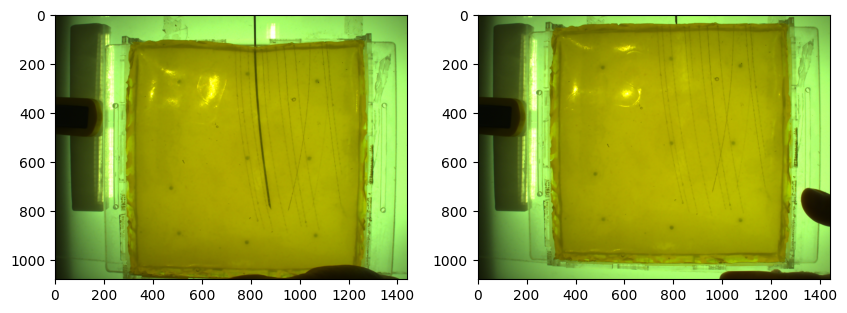

In [423]:
path = "needle_images_new/"
filename_full = 'needle_images_new/' + '2022-11-18_17-29-11_right_119.png'

filename = filename_full.split("/")[1]

ref_filename_full = path + "ref_"
for tmp in filename.split("_")[:-1]:
    ref_filename_full = ref_filename_full + tmp + "_"
ref_filename_full = ref_filename_full + "0.png"

# read image
img = cv2.cvtColor(cv2.imread(filename_full), cv2.COLOR_BGR2RGB)
ref = cv2.cvtColor(cv2.imread(ref_filename_full), cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,20))
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(ref)
plt.show()

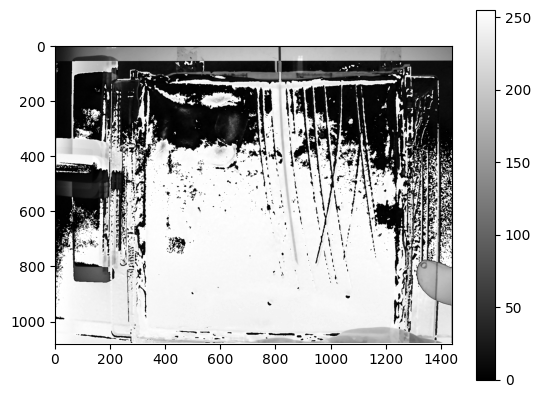

In [424]:
# Initiate ORB detector
orb = cv2.ORB_create()

# find the keypoints with ORB
kp1 = orb.detect(ref, None)
kp2 = orb.detect(img, None)

# compute the descriptors with ORB
kps1, des1 = orb.compute(ref, kp1)
kps2, des2 = orb.compute(img, kp2)

bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1, des2)
matches = sorted(matches, key=lambda x: x.distance)

match_img = cv2.drawMatches(
    ref,
    kps1,
    img,
    kps2,
    matches[:50],
    None,
    matchColor=(0, 255, 0),
    singlePointColor=(0, 255, 0),
)

transform, mask = estimate_transformation_ransac(
    kps1,
    kps2,
    matches,
    transform_func=get_homography,
    n_samples=5,
    n_trials=100,
    inlier_thresh=5,
)

warped_ref = cv2.warpPerspective(ref, transform, (img.shape[1], img.shape[0]))

img_diff = np.abs(
    cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    - cv2.cvtColor(warped_ref, cv2.COLOR_BGR2GRAY)
)

im = plt.imshow(img_diff, cmap='gray')
plt.colorbar(im)
plt.show()

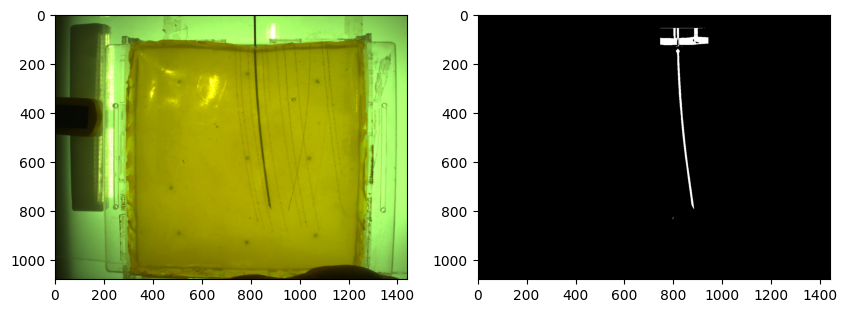

In [425]:
bb_dict = {
    "needle_images_new/ref_2022-11-18_17-29-11_left_0.png": [550, 0, 750, 800],
    "needle_images_new/ref_2022-11-18_17-29-11_right_0.png": [750, 0, 950, 800],
    "needle_images_new/ref_2022-11-21_21-14-25_left_0.png": [720, 0, 920, 850],
    "needle_images_new/ref_2022-11-21_21-14-25_right_0.png": [900, 0, 1100, 850],
    "needle_images_new/ref_2022-11-23_18-42-03_left_0.png": [700, 0, 900, 850],
    "needle_images_new/ref_2022-11-23_18-42-03_right_0.png": [900, 0, 1100, 900],
    "needle_images_new/ref_2022-11-23_19-07-54_left_0.png": [650, 0, 850, 800],
    "needle_images_new/ref_2022-11-23_19-07-54_right_0.png": [850, 0, 1100, 900],
}

bb = np.array(bb_dict[ref_filename_full])
bb = np.concatenate((bb.reshape((2, 2)).T, [[1, 1]]))
bb_ = transform @ bb
bb_ = np.round(bb_[0:2, :] / bb_[2, :]).astype(int)
bb_[bb_<0] = 0
# bb_tranform = [ bb_list[idx,:2]@transform.T, bb_list[idx,2:]@transform.T ]
# print([bb_list[idx,:2], 1]@transform.T)

mask = np.zeros(img_diff.shape)
mask[bb_[1, 0] : bb_[1, 1], bb_[0, 0] : bb_[0, 1]] = img_diff[
    bb_[1, 0] : bb_[1, 1], bb_[0, 0] : bb_[0, 1]
]
# mask = img_diff.copy()

mask[np.bitwise_or(mask > 220, mask < 50)] = 0
mask[mask != 0] = 1

plt.figure(figsize=(10,20))
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(mask, cmap='gray')
plt.show()

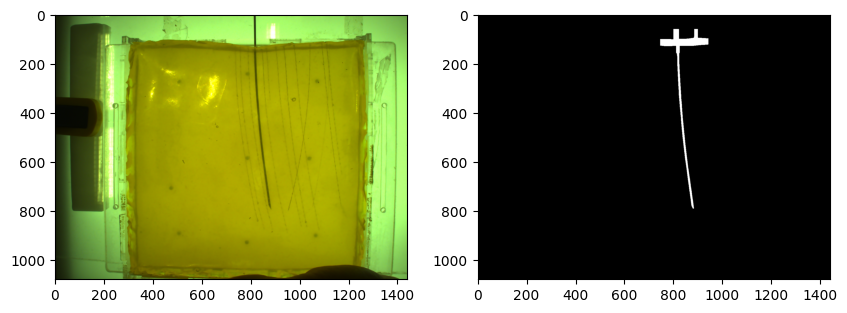

In [426]:
kernel_open = np.ones((3, 3), np.uint8)
mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel_open, iterations=2)

kernel_close = np.ones((10, 3), np.uint8)
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel_close, iterations=4)

plt.figure(figsize=(10,20))
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(mask, cmap='gray')
plt.show()


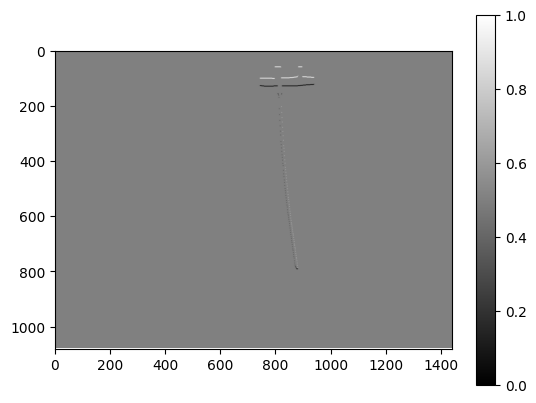

In [427]:
mask_sobely = cv2.Sobel(mask,cv2.CV_64F,0,1,ksize=5)
mask_sobely = (mask_sobely - np.min(mask_sobely)) / (np.max(mask_sobely)-np.min(mask_sobely))
im = plt.imshow(mask_sobely, cmap='gray')
plt.colorbar(im)
plt.show()

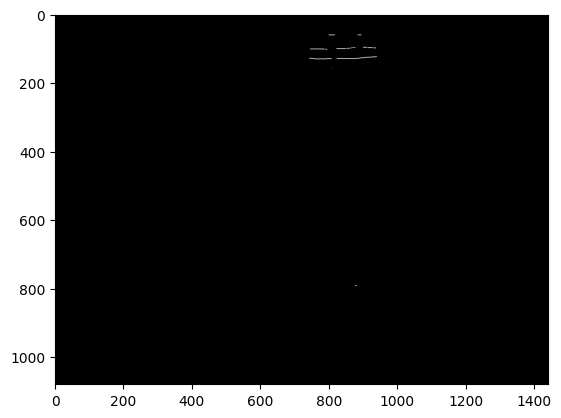

In [428]:
mask_sobely[mask_sobely<.2] = 1
mask_sobely[mask_sobely!=1] = 0
plt.imshow(mask_sobely, cmap='gray')
plt.show()

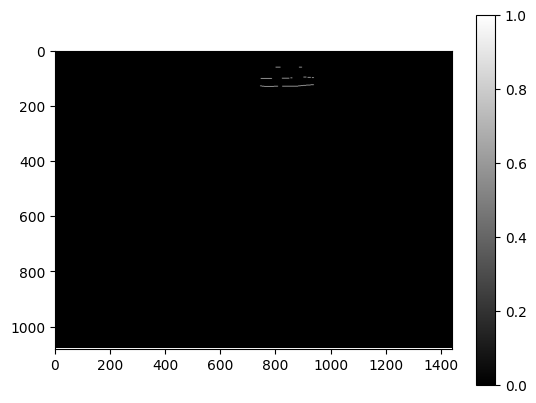

In [429]:
mask_sobely = cv2.morphologyEx(mask_sobely, cv2.MORPH_OPEN, np.ones((2,6)), iterations=1)
# mask_sobely[200:,:] = 0
im = plt.imshow(mask_sobely, cmap='gray')
plt.colorbar(im)
plt.show()

132


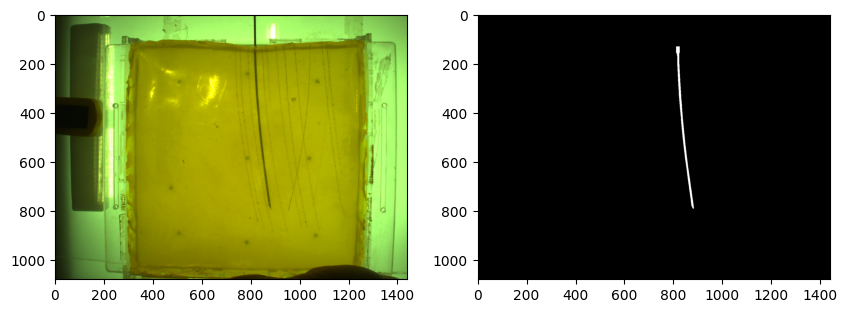

In [430]:
bb_upper = max(np.where(mask_sobely)[0])
print(bb_upper)

mask[:bb_upper,:] = 0
# mask[:, 1000:] = 0

plt.figure(figsize=(10,20))
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(mask, cmap='gray')
plt.show()

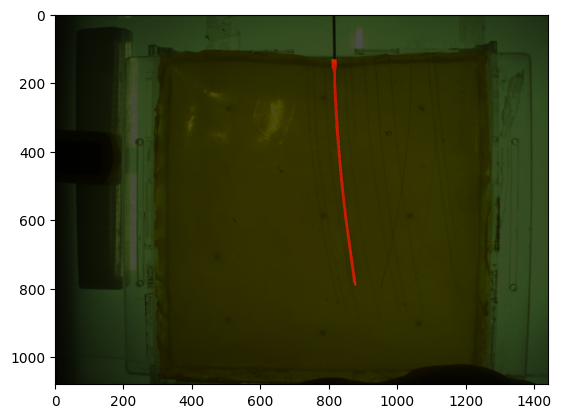

In [431]:
# plot
img_needle = np.zeros(img.shape, dtype=int)
img_needle[:, :, 0] = mask * 255
overlayed_img = 0.3 * img + 0.7 * img_needle
overlayed_img = overlayed_img.astype(np.uint8)

plt.imshow(overlayed_img, cmap='gray')
plt.show()

In [432]:
mask = mask.astype(bool)
overlayed_img = cv2.cvtColor(overlayed_img, cv2.COLOR_BGR2RGB)

mask_filename_full = "needle_masks_new/" + filename.split(".")[0] + "_mask.png"
im = Image.fromarray(mask)
im.save(mask_filename_full)

cv2.imwrite("needle_masks_new_ol/" + filename, overlayed_img)

True